<a href="https://colab.research.google.com/github/mahesh-ml/MLBasics/blob/main/Optuna_optimizeCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import os
os.environ['PYTHONHASHSEED'] = '0'
import numpy as np
import tensorflow as tf
import random as python_random

np.random.seed(123)
python_random.seed(123)

tf.random.set_seed(1234)

In [49]:
!pip install optuna
import optuna

In [50]:
import itertools
from functools import partial
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense,Flatten,Conv2D , MaxPool2D
from tensorflow.keras.optimizers import Adam,RMSprop



In [51]:
data = pd.read_csv("/content/mnist.csv")

In [52]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [53]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['label'],axis=1),data['label'],test_size=0.1, random_state=0)
X_train.shape, X_test.shape

((37800, 784), (4200, 784))

Text(0, 0.5, 'number of images')

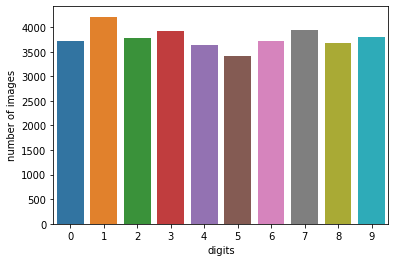

In [54]:
g = sns.countplot(x=y_train)
plt.xlabel("digits")
plt.ylabel('number of images')

In [55]:
#rescale and reshape
X_train= X_train / 255
X_test = X_test /255

#reshape
X_train=X_train.values.reshape(-1,28,28,1)
X_test=X_test.values.reshape(-1,28,28,1)


In [56]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)


y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [57]:
path_best_model='cnn_model.h5'
best_accuracy=0

In [58]:
#objective function
def objective(trial):
  model= Sequential()
  num_conv_layers= trial.suggest_int('num_conv_layers',1,3)

  for i in range(num_conv_layers):
    model.add(Conv2D(
                     filters=trial.suggest_categorical('filters',[16,32,64]),
                     kernel_size=trial.suggest_categorical('kernel_size',[3,5]),
                     strides=trial.suggest_categorical('strides',[1,2]),
                     activation= trial.suggest_categorical('activation',['relu','tanh']), padding='same'
              
              ))
    model.add(MaxPool2D(pool_size=trial.suggest_int('pool_size',2,3), strides=2))

    model.add(Flatten())

    num_dense_layers = trial.suggest_int('num_dense_layers', 1, 3)

    for i in range(num_dense_layers):
        model.add(Dense(
             units = trial.suggest_int('units', 5,512),
             activation = trial.suggest_categorical('activation',['relu','tanh'])
        ))
    model.add(Dense(10,activation='softmax'))

    optimizer_name = trial.suggest_categorical('optimizer_name',['Adam','RMRProp'])

    if optimizer_name == 'Adam':
       optimizer = Adam(learning_rate=trial.suggest_float('learning_rate',1e-6, 1e-2))
    else:
       optimizer = RMSprop(learning_rate=trial.suggest_float('learning_rate',1e-6, 1e-2), 
                           momentum = trial.suggest_float('momentum',0.1,0.9))
       
    #compile model
  
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    #train model
    history = model.fit(x=X_train, 
                        y = y_train, 
                        epochs=3, 
                        batch_size=128,
                        validation_split=0.1)

    #accuracy
    accuracy= history.history['val_accuracy'][-1]

    global best_accuracy

    if accuracy > best_accuracy:
        model.save(path_best_model)
        best_accuracy = accuracy

    del model

    return accuracy

In [59]:
study_name='cnn_study'
storage_name="sqlite:///{}.db".format(study_name)

In [60]:
study = optuna.create_study(
    direction='maximize',
    study_name=study_name,
    storage= storage_name,
    load_if_exists=True

)

study.optimize(objective, n_trials=30)

[I 2021-11-10 22:19:39,810] Using an existing study with name 'cnn_study' instead of creating a new one.


Epoch 1/3
266/266 [==============================] - 2s 7ms/step - loss: 0.2613 - accuracy: 0.9157 - val_loss: 0.1191 - val_accuracy: 0.9643
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0981 - accuracy: 0.9695 - val_loss: 0.1143 - val_accuracy: 0.9661
Epoch 3/3
266/266 [==============================] - 1s 6ms/step - loss: 0.0703 - accuracy: 0.9780 - val_loss: 0.0954 - val_accuracy: 0.9733


[I 2021-11-10 22:19:46,125] Trial 60 finished with value: 0.9732804298400879 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'pool_size': 3, 'num_dense_layers': 2, 'units': 158, 'optimizer_name': 'Adam', 'learning_rate': 0.005280242536130916}. Best is trial 36 with value: 0.9740740656852722.


Epoch 1/3
266/266 [==============================] - 2s 6ms/step - loss: 0.2647 - accuracy: 0.9176 - val_loss: 0.1247 - val_accuracy: 0.9606
Epoch 2/3
266/266 [==============================] - 1s 5ms/step - loss: 0.0885 - accuracy: 0.9716 - val_loss: 0.1011 - val_accuracy: 0.9706
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0648 - accuracy: 0.9792 - val_loss: 0.1066 - val_accuracy: 0.9696


[I 2021-11-10 22:19:52,289] Trial 61 finished with value: 0.9695767164230347 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'pool_size': 3, 'num_dense_layers': 2, 'units': 67, 'optimizer_name': 'Adam', 'learning_rate': 0.005294920816610469}. Best is trial 36 with value: 0.9740740656852722.


Epoch 1/3
266/266 [==============================] - 2s 7ms/step - loss: 0.2453 - accuracy: 0.9232 - val_loss: 0.1447 - val_accuracy: 0.9566
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0964 - accuracy: 0.9696 - val_loss: 0.1295 - val_accuracy: 0.9632
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0648 - accuracy: 0.9791 - val_loss: 0.0918 - val_accuracy: 0.9735


[I 2021-11-10 22:19:58,462] Trial 62 finished with value: 0.9735449552536011 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'pool_size': 2, 'num_dense_layers': 2, 'units': 98, 'optimizer_name': 'Adam', 'learning_rate': 0.0062520644849654635}. Best is trial 36 with value: 0.9740740656852722.


Epoch 1/3
266/266 [==============================] - 2s 7ms/step - loss: 0.2451 - accuracy: 0.9228 - val_loss: 0.1373 - val_accuracy: 0.9627
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.1027 - accuracy: 0.9676 - val_loss: 0.1268 - val_accuracy: 0.9624
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0653 - accuracy: 0.9799 - val_loss: 0.1029 - val_accuracy: 0.9725


[I 2021-11-10 22:20:04,347] Trial 63 finished with value: 0.9724867939949036 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'pool_size': 2, 'num_dense_layers': 2, 'units': 96, 'optimizer_name': 'Adam', 'learning_rate': 0.006942573667233457}. Best is trial 36 with value: 0.9740740656852722.


Epoch 1/3
266/266 [==============================] - 2s 7ms/step - loss: 0.2466 - accuracy: 0.9232 - val_loss: 0.1469 - val_accuracy: 0.9553
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.1091 - accuracy: 0.9661 - val_loss: 0.1203 - val_accuracy: 0.9643
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0810 - accuracy: 0.9753 - val_loss: 0.1037 - val_accuracy: 0.9690


[I 2021-11-10 22:20:10,462] Trial 64 finished with value: 0.9690476059913635 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'pool_size': 2, 'num_dense_layers': 2, 'units': 171, 'optimizer_name': 'Adam', 'learning_rate': 0.006873264549503881}. Best is trial 36 with value: 0.9740740656852722.


Epoch 1/3
266/266 [==============================] - 2s 6ms/step - loss: 0.2502 - accuracy: 0.9208 - val_loss: 0.1629 - val_accuracy: 0.9505
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0989 - accuracy: 0.9686 - val_loss: 0.1089 - val_accuracy: 0.9661
Epoch 3/3
266/266 [==============================] - 1s 6ms/step - loss: 0.0677 - accuracy: 0.9783 - val_loss: 0.1073 - val_accuracy: 0.9677


[I 2021-11-10 22:20:17,031] Trial 65 finished with value: 0.9677248597145081 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'pool_size': 2, 'num_dense_layers': 2, 'units': 102, 'optimizer_name': 'Adam', 'learning_rate': 0.00672344773724067}. Best is trial 36 with value: 0.9740740656852722.


Epoch 1/3
266/266 [==============================] - 2s 7ms/step - loss: 0.2342 - accuracy: 0.9259 - val_loss: 0.1115 - val_accuracy: 0.9669
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0834 - accuracy: 0.9735 - val_loss: 0.1337 - val_accuracy: 0.9651
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0585 - accuracy: 0.9813 - val_loss: 0.0802 - val_accuracy: 0.9786


[I 2021-11-10 22:20:23,194] Trial 66 finished with value: 0.9785714149475098 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'pool_size': 2, 'num_dense_layers': 2, 'units': 122, 'optimizer_name': 'Adam', 'learning_rate': 0.007629720010923141}. Best is trial 66 with value: 0.9785714149475098.


Epoch 1/3
266/266 [==============================] - 2s 7ms/step - loss: 0.2455 - accuracy: 0.9200 - val_loss: 0.1119 - val_accuracy: 0.9675
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0808 - accuracy: 0.9748 - val_loss: 0.0965 - val_accuracy: 0.9728
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0582 - accuracy: 0.9812 - val_loss: 0.1069 - val_accuracy: 0.9735


[I 2021-11-10 22:20:29,324] Trial 67 finished with value: 0.9735449552536011 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'pool_size': 2, 'num_dense_layers': 2, 'units': 125, 'optimizer_name': 'Adam', 'learning_rate': 0.007881870093850146}. Best is trial 66 with value: 0.9785714149475098.


Epoch 1/3
266/266 [==============================] - 2s 7ms/step - loss: 0.2433 - accuracy: 0.9215 - val_loss: 0.1154 - val_accuracy: 0.9653
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0828 - accuracy: 0.9744 - val_loss: 0.0873 - val_accuracy: 0.9735
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0561 - accuracy: 0.9825 - val_loss: 0.0851 - val_accuracy: 0.9757


[I 2021-11-10 22:20:35,426] Trial 68 finished with value: 0.9756613969802856 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'pool_size': 2, 'num_dense_layers': 2, 'units': 150, 'optimizer_name': 'Adam', 'learning_rate': 0.007802188186666907}. Best is trial 66 with value: 0.9785714149475098.


Epoch 1/3
266/266 [==============================] - 2s 7ms/step - loss: 0.2600 - accuracy: 0.9163 - val_loss: 0.1204 - val_accuracy: 0.9616
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0930 - accuracy: 0.9728 - val_loss: 0.0959 - val_accuracy: 0.9735
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0631 - accuracy: 0.9807 - val_loss: 0.0942 - val_accuracy: 0.9728


[I 2021-11-10 22:20:46,718] Trial 69 finished with value: 0.9727513194084167 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'pool_size': 2, 'num_dense_layers': 3, 'units': 196, 'optimizer_name': 'Adam', 'learning_rate': 0.008464590127699791}. Best is trial 66 with value: 0.9785714149475098.


Epoch 1/3
266/266 [==============================] - 2s 7ms/step - loss: 0.2354 - accuracy: 0.9217 - val_loss: 0.1126 - val_accuracy: 0.9661
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0817 - accuracy: 0.9745 - val_loss: 0.0968 - val_accuracy: 0.9720
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0614 - accuracy: 0.9803 - val_loss: 0.0953 - val_accuracy: 0.9730


[I 2021-11-10 22:20:52,858] Trial 70 finished with value: 0.9730158448219299 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'pool_size': 3, 'num_dense_layers': 2, 'units': 240, 'optimizer_name': 'Adam', 'learning_rate': 0.007557098194603235}. Best is trial 66 with value: 0.9785714149475098.


Epoch 1/3
266/266 [==============================] - 2s 6ms/step - loss: 0.2420 - accuracy: 0.9202 - val_loss: 0.1185 - val_accuracy: 0.9627
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0856 - accuracy: 0.9730 - val_loss: 0.0998 - val_accuracy: 0.9733
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0636 - accuracy: 0.9794 - val_loss: 0.0878 - val_accuracy: 0.9762


[I 2021-11-10 22:20:58,966] Trial 71 finished with value: 0.976190447807312 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'pool_size': 3, 'num_dense_layers': 2, 'units': 243, 'optimizer_name': 'Adam', 'learning_rate': 0.007669498119600356}. Best is trial 66 with value: 0.9785714149475098.


Epoch 1/3
266/266 [==============================] - 2s 7ms/step - loss: 0.2310 - accuracy: 0.9237 - val_loss: 0.1209 - val_accuracy: 0.9614
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0824 - accuracy: 0.9739 - val_loss: 0.0972 - val_accuracy: 0.9712
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0615 - accuracy: 0.9809 - val_loss: 0.1033 - val_accuracy: 0.9690


[I 2021-11-10 22:21:05,086] Trial 72 finished with value: 0.9690476059913635 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'pool_size': 3, 'num_dense_layers': 2, 'units': 146, 'optimizer_name': 'Adam', 'learning_rate': 0.008465823698048262}. Best is trial 66 with value: 0.9785714149475098.


Epoch 1/3
266/266 [==============================] - 2s 6ms/step - loss: 0.2444 - accuracy: 0.9217 - val_loss: 0.1119 - val_accuracy: 0.9659
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0862 - accuracy: 0.9722 - val_loss: 0.1276 - val_accuracy: 0.9640
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0567 - accuracy: 0.9812 - val_loss: 0.0800 - val_accuracy: 0.9772


[I 2021-11-10 22:21:11,198] Trial 73 finished with value: 0.9772486686706543 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'pool_size': 2, 'num_dense_layers': 2, 'units': 124, 'optimizer_name': 'Adam', 'learning_rate': 0.00783816905004461}. Best is trial 66 with value: 0.9785714149475098.


Epoch 1/3
266/266 [==============================] - 2s 7ms/step - loss: 0.2631 - accuracy: 0.9152 - val_loss: 0.1170 - val_accuracy: 0.9646
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0844 - accuracy: 0.9728 - val_loss: 0.1323 - val_accuracy: 0.9608
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0595 - accuracy: 0.9806 - val_loss: 0.0971 - val_accuracy: 0.9720


[I 2021-11-10 22:21:17,331] Trial 74 finished with value: 0.9719576835632324 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'pool_size': 2, 'num_dense_layers': 2, 'units': 115, 'optimizer_name': 'Adam', 'learning_rate': 0.007829758219434855}. Best is trial 66 with value: 0.9785714149475098.


Epoch 1/3
266/266 [==============================] - 2s 6ms/step - loss: 0.2191 - accuracy: 0.9299 - val_loss: 0.1088 - val_accuracy: 0.9701
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0791 - accuracy: 0.9755 - val_loss: 0.1189 - val_accuracy: 0.9669
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0534 - accuracy: 0.9826 - val_loss: 0.0987 - val_accuracy: 0.9738


[I 2021-11-10 22:21:23,282] Trial 75 finished with value: 0.973809540271759 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'pool_size': 2, 'num_dense_layers': 2, 'units': 178, 'optimizer_name': 'Adam', 'learning_rate': 0.008052006510838457}. Best is trial 66 with value: 0.9785714149475098.


Epoch 1/3
266/266 [==============================] - 2s 7ms/step - loss: 0.2170 - accuracy: 0.9315 - val_loss: 0.1126 - val_accuracy: 0.9661
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0799 - accuracy: 0.9746 - val_loss: 0.0977 - val_accuracy: 0.9704
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0572 - accuracy: 0.9822 - val_loss: 0.0922 - val_accuracy: 0.9730


[I 2021-11-10 22:21:29,444] Trial 76 finished with value: 0.9730158448219299 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'pool_size': 2, 'num_dense_layers': 2, 'units': 226, 'optimizer_name': 'Adam', 'learning_rate': 0.008739673909515864}. Best is trial 66 with value: 0.9785714149475098.


Epoch 1/3
266/266 [==============================] - 2s 7ms/step - loss: 0.2374 - accuracy: 0.9243 - val_loss: 0.1122 - val_accuracy: 0.9683
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0880 - accuracy: 0.9729 - val_loss: 0.1201 - val_accuracy: 0.9685
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0643 - accuracy: 0.9798 - val_loss: 0.0971 - val_accuracy: 0.9725


[I 2021-11-10 22:21:35,588] Trial 77 finished with value: 0.9724867939949036 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'pool_size': 2, 'num_dense_layers': 2, 'units': 200, 'optimizer_name': 'Adam', 'learning_rate': 0.009254939522062258}. Best is trial 66 with value: 0.9785714149475098.


Epoch 1/3
266/266 [==============================] - 3s 7ms/step - loss: 0.2387 - accuracy: 0.9223 - val_loss: 0.1323 - val_accuracy: 0.9606
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0839 - accuracy: 0.9738 - val_loss: 0.0852 - val_accuracy: 0.9754
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0519 - accuracy: 0.9833 - val_loss: 0.0914 - val_accuracy: 0.9754


[I 2021-11-10 22:21:42,291] Trial 78 finished with value: 0.9753968119621277 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'pool_size': 2, 'num_dense_layers': 2, 'units': 141, 'optimizer_name': 'Adam', 'learning_rate': 0.00808471422736561}. Best is trial 66 with value: 0.9785714149475098.


Epoch 1/3
266/266 [==============================] - 3s 9ms/step - loss: 0.2176 - accuracy: 0.9295 - val_loss: 0.0923 - val_accuracy: 0.9725
Epoch 2/3
266/266 [==============================] - 2s 8ms/step - loss: 0.0707 - accuracy: 0.9782 - val_loss: 0.1077 - val_accuracy: 0.9696
Epoch 3/3
266/266 [==============================] - 2s 8ms/step - loss: 0.0512 - accuracy: 0.9838 - val_loss: 0.0808 - val_accuracy: 0.9746


[I 2021-11-10 22:21:49,749] Trial 79 finished with value: 0.9746031761169434 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'pool_size': 2, 'num_dense_layers': 2, 'units': 174, 'optimizer_name': 'Adam', 'learning_rate': 0.008092938842880511}. Best is trial 66 with value: 0.9785714149475098.


Epoch 1/3
266/266 [==============================] - 3s 9ms/step - loss: 0.2257 - accuracy: 0.9276 - val_loss: 0.1023 - val_accuracy: 0.9712
Epoch 2/3
266/266 [==============================] - 2s 8ms/step - loss: 0.0734 - accuracy: 0.9772 - val_loss: 0.0799 - val_accuracy: 0.9791
Epoch 3/3
266/266 [==============================] - 2s 8ms/step - loss: 0.0502 - accuracy: 0.9842 - val_loss: 0.0899 - val_accuracy: 0.9799


[I 2021-11-10 22:22:01,144] Trial 80 finished with value: 0.9798941612243652 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'pool_size': 2, 'num_dense_layers': 2, 'units': 172, 'optimizer_name': 'Adam', 'learning_rate': 0.008013102492516319}. Best is trial 80 with value: 0.9798941612243652.


Epoch 1/3
266/266 [==============================] - 3s 9ms/step - loss: 0.2124 - accuracy: 0.9314 - val_loss: 0.0968 - val_accuracy: 0.9696
Epoch 2/3
266/266 [==============================] - 2s 8ms/step - loss: 0.0740 - accuracy: 0.9764 - val_loss: 0.0797 - val_accuracy: 0.9780
Epoch 3/3
266/266 [==============================] - 2s 8ms/step - loss: 0.0489 - accuracy: 0.9840 - val_loss: 0.0946 - val_accuracy: 0.9759


[I 2021-11-10 22:22:08,752] Trial 81 finished with value: 0.9759259223937988 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'pool_size': 2, 'num_dense_layers': 2, 'units': 178, 'optimizer_name': 'Adam', 'learning_rate': 0.0073778435794977625}. Best is trial 80 with value: 0.9798941612243652.


Epoch 1/3
266/266 [==============================] - 3s 9ms/step - loss: 0.2085 - accuracy: 0.9336 - val_loss: 0.1208 - val_accuracy: 0.9638
Epoch 2/3
266/266 [==============================] - 2s 8ms/step - loss: 0.0692 - accuracy: 0.9791 - val_loss: 0.0976 - val_accuracy: 0.9725
Epoch 3/3
266/266 [==============================] - 2s 8ms/step - loss: 0.0517 - accuracy: 0.9834 - val_loss: 0.0769 - val_accuracy: 0.9778


[I 2021-11-10 22:22:16,717] Trial 82 finished with value: 0.9777777791023254 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'pool_size': 2, 'num_dense_layers': 2, 'units': 275, 'optimizer_name': 'Adam', 'learning_rate': 0.0072358951716174815}. Best is trial 80 with value: 0.9798941612243652.


Epoch 1/3
266/266 [==============================] - 3s 9ms/step - loss: 0.1974 - accuracy: 0.9353 - val_loss: 0.0940 - val_accuracy: 0.9717
Epoch 2/3
266/266 [==============================] - 2s 8ms/step - loss: 0.0728 - accuracy: 0.9772 - val_loss: 0.1016 - val_accuracy: 0.9717
Epoch 3/3
266/266 [==============================] - 2s 8ms/step - loss: 0.0465 - accuracy: 0.9854 - val_loss: 0.0775 - val_accuracy: 0.9757


[I 2021-11-10 22:22:24,620] Trial 83 finished with value: 0.9756613969802856 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'pool_size': 2, 'num_dense_layers': 2, 'units': 279, 'optimizer_name': 'Adam', 'learning_rate': 0.007324663222072133}. Best is trial 80 with value: 0.9798941612243652.


Epoch 1/3
266/266 [==============================] - 3s 9ms/step - loss: 0.2131 - accuracy: 0.9317 - val_loss: 0.0890 - val_accuracy: 0.9738
Epoch 2/3
266/266 [==============================] - 2s 8ms/step - loss: 0.0665 - accuracy: 0.9795 - val_loss: 0.0795 - val_accuracy: 0.9788
Epoch 3/3
266/266 [==============================] - 2s 8ms/step - loss: 0.0465 - accuracy: 0.9850 - val_loss: 0.0812 - val_accuracy: 0.9794


[I 2021-11-10 22:22:35,873] Trial 84 finished with value: 0.9793650507926941 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'pool_size': 2, 'num_dense_layers': 2, 'units': 280, 'optimizer_name': 'Adam', 'learning_rate': 0.007439582187097607}. Best is trial 80 with value: 0.9798941612243652.


Epoch 1/3
266/266 [==============================] - 3s 9ms/step - loss: 0.2081 - accuracy: 0.9323 - val_loss: 0.0977 - val_accuracy: 0.9696
Epoch 2/3
266/266 [==============================] - 2s 8ms/step - loss: 0.0683 - accuracy: 0.9792 - val_loss: 0.0947 - val_accuracy: 0.9757
Epoch 3/3
266/266 [==============================] - 2s 8ms/step - loss: 0.0489 - accuracy: 0.9845 - val_loss: 0.0850 - val_accuracy: 0.9802


[I 2021-11-10 22:22:44,172] Trial 85 finished with value: 0.9801587462425232 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'pool_size': 2, 'num_dense_layers': 2, 'units': 297, 'optimizer_name': 'Adam', 'learning_rate': 0.007368314178053586}. Best is trial 85 with value: 0.9801587462425232.


Epoch 1/3
266/266 [==============================] - 3s 9ms/step - loss: 0.2096 - accuracy: 0.9328 - val_loss: 0.1029 - val_accuracy: 0.9683
Epoch 2/3
266/266 [==============================] - 2s 8ms/step - loss: 0.0751 - accuracy: 0.9765 - val_loss: 0.0973 - val_accuracy: 0.9728
Epoch 3/3
266/266 [==============================] - 2s 8ms/step - loss: 0.0450 - accuracy: 0.9859 - val_loss: 0.1025 - val_accuracy: 0.9741


[I 2021-11-10 22:22:55,402] Trial 86 finished with value: 0.9740740656852722 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'pool_size': 2, 'num_dense_layers': 2, 'units': 294, 'optimizer_name': 'Adam', 'learning_rate': 0.007291551996807878}. Best is trial 85 with value: 0.9801587462425232.


Epoch 1/3
266/266 [==============================] - 3s 9ms/step - loss: 0.2058 - accuracy: 0.9338 - val_loss: 0.0944 - val_accuracy: 0.9725
Epoch 2/3
266/266 [==============================] - 2s 8ms/step - loss: 0.0706 - accuracy: 0.9786 - val_loss: 0.0865 - val_accuracy: 0.9754
Epoch 3/3
266/266 [==============================] - 2s 8ms/step - loss: 0.0469 - accuracy: 0.9850 - val_loss: 0.0866 - val_accuracy: 0.9767


[I 2021-11-10 22:23:06,639] Trial 87 finished with value: 0.9767195582389832 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'pool_size': 2, 'num_dense_layers': 2, 'units': 277, 'optimizer_name': 'Adam', 'learning_rate': 0.007482107506295036}. Best is trial 85 with value: 0.9801587462425232.


Epoch 1/3
266/266 [==============================] - 3s 9ms/step - loss: 0.2198 - accuracy: 0.9299 - val_loss: 0.1010 - val_accuracy: 0.9709
Epoch 2/3
266/266 [==============================] - 2s 8ms/step - loss: 0.0730 - accuracy: 0.9774 - val_loss: 0.0809 - val_accuracy: 0.9778
Epoch 3/3
266/266 [==============================] - 2s 8ms/step - loss: 0.0493 - accuracy: 0.9842 - val_loss: 0.0915 - val_accuracy: 0.9754


[I 2021-11-10 22:23:17,896] Trial 88 finished with value: 0.9753968119621277 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'pool_size': 2, 'num_dense_layers': 2, 'units': 258, 'optimizer_name': 'Adam', 'learning_rate': 0.007458691564044282}. Best is trial 85 with value: 0.9801587462425232.


Epoch 1/3
266/266 [==============================] - 3s 9ms/step - loss: 0.1930 - accuracy: 0.9385 - val_loss: 0.1085 - val_accuracy: 0.9698
Epoch 2/3
266/266 [==============================] - 2s 9ms/step - loss: 0.0752 - accuracy: 0.9768 - val_loss: 0.0976 - val_accuracy: 0.9743
Epoch 3/3
266/266 [==============================] - 2s 9ms/step - loss: 0.0499 - accuracy: 0.9859 - val_loss: 0.0817 - val_accuracy: 0.9791


[I 2021-11-10 22:23:29,171] Trial 89 finished with value: 0.9791005253791809 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'pool_size': 2, 'num_dense_layers': 2, 'units': 293, 'optimizer_name': 'Adam', 'learning_rate': 0.008892613644920576}. Best is trial 85 with value: 0.9801587462425232.


In [61]:
study.best_params


{'activation': 'relu',
 'filters': 64,
 'kernel_size': 3,
 'learning_rate': 0.007368314178053586,
 'num_conv_layers': 3,
 'num_dense_layers': 2,
 'optimizer_name': 'Adam',
 'pool_size': 2,
 'strides': 2,
 'units': 297}

In [62]:
study.best_value

0.9801587462425232

Text(0, 0.5, 'Accuracy')

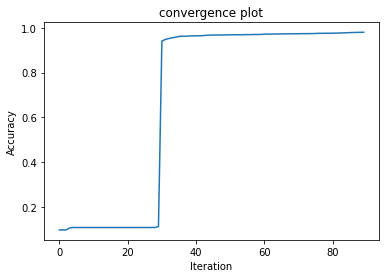

In [63]:
#analyze result


results = study.trials_dataframe()

results['value'].sort_values().reset_index(drop=True).plot()
plt.title('convergence plot')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

In [64]:
#Evaluate
model = load_model(path_best_model)

model.summary()

Model: "sequential_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_85 (Conv2D)          (None, 14, 14, 64)        640       
                                                                 
 max_pooling2d_85 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                            
                                                                 
 flatten_85 (Flatten)        (None, 3136)              0         
                                                                 
 dense_245 (Dense)           (None, 297)               931689    
                                                                 
 dense_246 (Dense)           (None, 297)               88506     
                                                                 
 dense_247 (Dense)           (None, 10)                2980      
                                                     

In [65]:
results = model.evaluate(x=X_test, y = y_test)

132/132 [==============================] - 1s 4ms/step - loss: 0.0784 - accuracy: 0.9783


In [66]:
for name , value in zip(model.metrics_names,results):
  print(name, value)

loss 0.07840806990861893
accuracy 0.9783333539962769


In [67]:
#confuison matrix
y_pred = model.predict(X_test)
y_pred_classes= np.argmax(y_pred, axis=1)
y_true= np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

cm


array([[420,   0,   0,   0,   0,   0,   2,   0,   0,   0],
       [  0, 466,   4,   0,   0,   0,   1,   0,   2,   0],
       [  0,   1, 407,   0,   0,   0,   0,   0,   1,   0],
       [  0,   1,   2, 409,   0,   5,   0,   5,   2,   2],
       [  1,   1,   0,   0, 422,   0,   3,   0,   0,   2],
       [  0,   0,   0,   0,   0, 373,   3,   0,   2,   4],
       [  0,   0,   1,   0,   2,   1, 408,   0,   0,   0],
       [  0,   1,   8,   0,   0,   1,   0, 455,   1,   3],
       [  0,   1,   1,   2,   0,   4,   2,   0, 374,   0],
       [  4,   0,   1,   0,   4,   1,   1,   7,   1, 375]])

Text(0.5, 13.421126458070283, 'Predicted label')

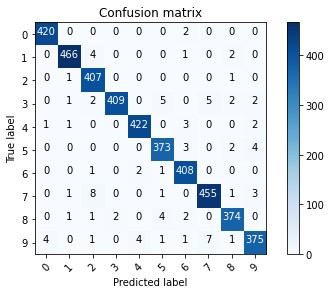

In [68]:
# let's make it more colourful
classes = 10

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes), rotation=45)
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > 100 else "black",
            )

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')